In [1]:
# Imports 
import sys
from pathlib import Path

# Add project root to path
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [319]:
import tifffile
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import networkx as nx

from scipy.spatial import Delaunay
from src.models.model_loader import ModelLoader
from src.utils.helpers import compare_two_images
from skimage.measure import label
from scipy.spatial import Delaunay
from collections import defaultdict
from stardist.models import StarDist2D
from stardist.plot import render_label
from src.utils.helpers import cut_out_image
from skimage.exposure import rescale_intensity
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine

In [3]:
# Load four images, which present a good example of layers
LAYER_PATH = project_root / "data/layer_examples"

paths = [(LAYER_PATH / image_path) for image_path in os.listdir(LAYER_PATH)]
images = list(map(tifffile.imread, paths))

In [4]:
# Normalize images
from src.utils.reinhard_normalizer import ReinhardNormalizer

normalizer = ReinhardNormalizer()
images = [normalizer.normalize(img) for img in images]

|2025-12-13|21:02:42.515| [WARNING] /opt/anaconda3/envs/research_project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

objc[27445]: Class GNotificationCenterDelegate is implemented in both /opt/anaconda3/envs/research_project/lib/libgio-2.0.0.dylib (0x36d0646d8) and /opt/anaconda3/envs/research_project/lib/python3.12/site-packages/openslide_bin/libopenslide.1.dylib (0x3769a1318). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
|2025-12-13|21:02:55.087| [WARNING] /opt/anaconda3/envs/research_project/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the enviro

# Create Tissue Masks

In [7]:
# Specify model to load
model_loader = ModelLoader()
MODEL_CFG = "unet_2"
model = model_loader.load_cnn_model(MODEL_CFG, "unet_2c")

Loaded CNN: unet_2c


In [8]:
from src.data.preprocessing import inference_processing
from skimage.transform import resize
ORG_RES = (1920, 2560)

In [9]:
masks = []
labeled_tissues = []
device = "mps" if torch.mps.is_available() else "cpu"
print(device)
for img in images:
    img = inference_processing(img, device)

    with torch.no_grad():
        pred_logits = model(img)
        pred_mask = torch.argmax(pred_logits, dim=1).squeeze()
        pred_mask = pred_mask.cpu().numpy()
        pred_mask = resize(pred_mask, ORG_RES, anti_aliasing=True)
    labeled_tissue = label(pred_mask > 0, connectivity=2)
    labeled_tissues.append(labeled_tissue)
    masks.append(pred_mask)

mps


In [379]:
# for img, mask in zip(images, masks):
#     compare_two_images(img, mask, "Normalized Image", "Predicted Mask")

# Segment Nuclei

In [13]:
stardist_model = StarDist2D.from_pretrained("2D_versatile_he")

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [285]:
nuclei_masks = []
nuclei_data_dicts = []

for img, mask in zip(images, masks):
    image_normed = rescale_intensity(img, out_range=(0, 1))
    labels, data_dict = stardist_model.predict_instances(image_normed, axes='YXC', prob_thresh=0.25, nms_thresh=0.01, return_labels=True)
    filtered_labels = cut_out_image(labels, mask)
    binary_labels = (filtered_labels > 0).astype(np.uint8)
    nuclei_masks.append(binary_labels)
    nuclei_data_dicts.append(data_dict)

In [378]:
# for img, mask in zip(images, nuclei_masks):
#     compare_two_images(img, mask, "Normalized Image", "Filtered nuclei mask")

# Clean Segmentation

In [287]:
def poly_area(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [288]:
def calculate_median_area(coordinates: np.ndarray) -> float:
    areas = []
    for coord in coordinates:
        area = poly_area(np.array(coord[0]), np.array(coord[1]))
        areas.append(area)
    
    median_area = np.median(np.array(areas))
    return median_area

In [289]:
def filter_data_dict_mask(mask: np.ndarray, data_dict: dict[str, any]) -> list:
    points = data_dict["points"]
    filtered_points = []
    binary_mask = (mask > 0).astype(int)
    for point, coord in zip(points, data_dict["coord"]):
        x, y = int(point[0]), int(point[1])
        if binary_mask[x, y] == 1:
            filtered_points.append([point[0], point[1]])

    filtered_data_dict = dict(data_dict)
    filtered_data_dict["points"] = np.array(filtered_points)
    
    return filtered_data_dict

In [290]:
def filter_data_dict(mask: np.ndarray, data_dict: dict[str, any]) -> list:
    points = data_dict["points"]
    median_area = calculate_median_area(data_dict["coord"])
    filtered_points = []
    filtered_coords = []
    filtered_probs = []

    binary_mask = (mask > 0).astype(int)
    for i, (point, coord) in enumerate(zip(points, data_dict["coord"])):
        x, y = int(point[0]), int(point[1])
        area = poly_area(np.array(coord[0]), np.array(coord[1]))
        if binary_mask[x, y] == 1 and area > 0.5 * median_area:
            filtered_points.append([point[0], point[1]])
            filtered_coords.append(coord)
            filtered_probs.append(data_dict["prob"][i])

    filtered_data_dict = dict(data_dict)
    filtered_data_dict["points"] = np.array(filtered_points)
    filtered_data_dict["coord"] = np.array(filtered_coords)
    filtered_data_dict["prob"] = np.array(filtered_probs)
    
    return filtered_data_dict

In [291]:
def plot_image_and_points(image: np.ndarray, data_dict: dict[str,np.ndarray]) -> None:
    points = data_dict["points"]
    height, width = image.shape[:2]
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.scatter(points[:, 1], points[:, 0], s=5)
    plt.xlim(0, width)
    plt.ylim(height, 0)
    plt.axis("off")
    plt.gca().set_aspect('equal')
    plt.show()

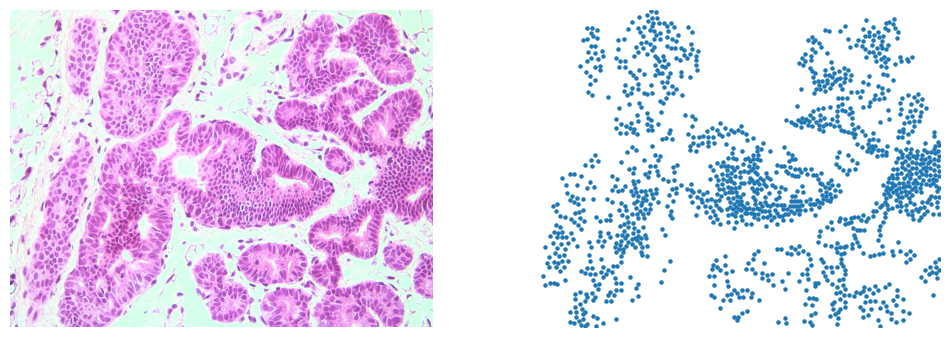

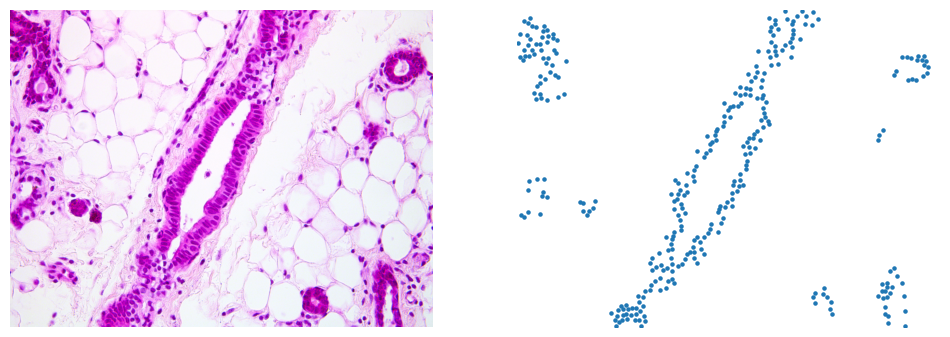

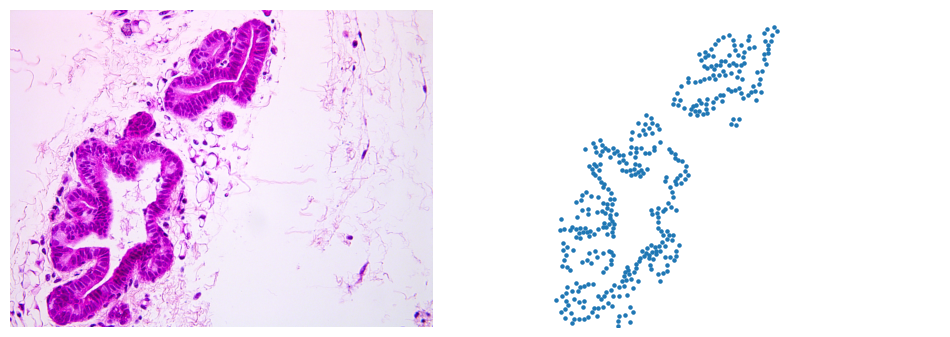

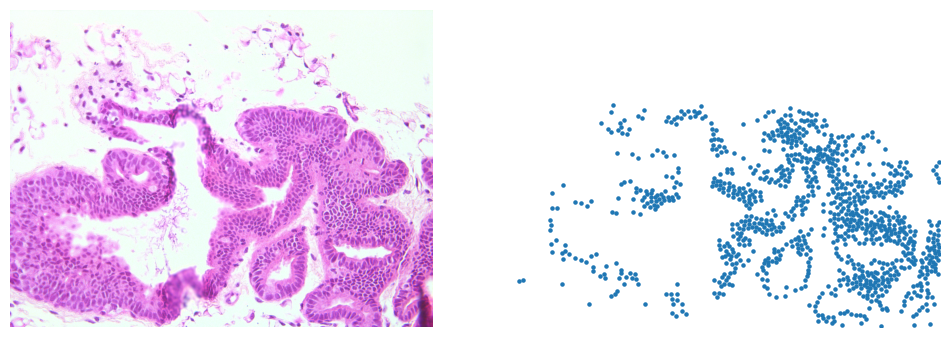

In [ ]:
# for image, mask, data_dict in zip(images, masks, nuclei_data_dicts):
#     filtered_data_dict = filter_data_dict(mask, data_dict)
#     plot_image_and_points(image, filtered_data_dict)

In [293]:
def plot_image_with_points(image: np.ndarray, data_dict: dict[str,np.ndarray]) -> None:
    plt.figure(figsize=(12, 12))
    points = data_dict["points"]
    plt.imshow(image)
    plt.plot(points[:, 1], points[:, 0], 'o', 
             color='blue', markersize=3, alpha=0.8)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [315]:
def compare_images_with_points(image_1: np.ndarray, data_dict_1: dict[str,np.ndarray], image_2: np.ndarray, data_dict_2: dict[str, np.ndarray]) -> None:
    plt.figure(figsize=(18, 12))

    plt.subplot(1, 2, 1)
    points_1 = data_dict_1["points"]
    plt.imshow(image_1)
    plt.plot(points_1[:, 1], points_1[:, 0], 'o', 
             color='blue', markersize=3, alpha=0.8)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    points_2 = data_dict_2["points"]
    plt.imshow(image_2)
    plt.plot(points_2[:, 1], points_2[:, 0], 'o', 
             color='blue', markersize=3, alpha=0.8)
    plt.axis('off')


    plt.tight_layout()
    plt.show()

In [377]:
# for image, mask, data_dict in zip(images, masks, nuclei_data_dicts):
#     filtered_data_dict = filter_data_dict(mask, data_dict)
#     plot_image_with_points(image, filtered_data_dict)

In [376]:
# # Plot without size filtering and compare
# for image, mask, data_dict in zip(images, masks, nuclei_data_dicts):
#     filtered_data_dict = filter_data_dict_mask(mask, data_dict)
#     plot_image_with_points(image, filtered_data_dict)

In [311]:
def recompute_nuclei_centers(data_dict: dict[str,any]) -> dict[str,any]:
    points = data_dict["points"]
    corrected_points = []
    coords = data_dict["coord"]
    for i, coord in enumerate(coords):
        mean_x = np.round(np.mean(coord[0]))
        mean_y = np.round(np.mean(coord[1]))
        corrected_points.append([mean_x, mean_y])
    
    recentered_dict = dict(data_dict)
    recentered_dict["points"] = np.array(corrected_points)

    return recentered_dict

In [375]:
# # Plot without size filtering and compare
# for image, mask, data_dict in zip(images, masks, nuclei_data_dicts):
#     filtered_data_dict = filter_data_dict(mask, data_dict)
#     centered_data_dict = recompute_nuclei_centers(filtered_data_dict)
#     compare_images_with_points(image, filtered_data_dict, image, centered_data_dict)

# Graph Layer Detection

In [ ]:
import networkx as nx
from scipy.spatial import Delaunay

In [ ]:
# Find neighbors

def get_delaunay_neighbors(points):
    points = np.array(points)
    tri = Delaunay(points)
    
    neighbors = defaultdict(set)
    
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(3):
                if i != j:
                    neighbors[simplex[i]].add(simplex[j])
    
    return dict(neighbors), points

In [332]:
test_points = np.array([[1, 2, 3, 2, 1, 2], [-3, -2, -1, 0, -1, -2]])

In [333]:
test_points.shape

(2, 6)

In [334]:
means = test_points.mean(axis=0)
means

array([-1.,  0.,  1.,  1.,  0.,  0.])

In [335]:
means.shape

(6,)

In [336]:
test_points.T.mean(axis=0).shape

(2,)

In [ ]:
def get_nucleus_orientation(boundary_points):
    boundary_points = np.array(boundary_points)
    
    if boundary_points.shape[0] == 2:
        boundary_points = boundary_points.T

    # Center the points
    centroid = boundary_points.mean(axis=0)
    centered = boundary_points - centroid
    
    # PCA to find main axis
    pca = PCA(n_components=2)
    pca.fit(centered)
    
    # First principal component is the main axis
    main_axis = pca.components_[0]
    
    return main_axis

In [ ]:
def calculate_alignment_similarity(main_axis: np.ndarray, compared_axis: np.ndarray) -> float:
    norm_main = np.linalg.norm(main_axis)
    norm_compared = np.linalg.norm(compared_axis)
    
    if norm_main == 0 or norm_compared == 0:
        return 0.0
    
    cosine_similarity = np.dot(main_axis, compared_axis) / (norm_main * norm_compared)
    return np.abs(cosine_similarity)

In [371]:
from math import atan2,degrees

def calculate_alignment_angle(main_point: tuple[int, int], compared_point: tuple[int, int]) -> int:
    if main_point[1] > compared_point[1]:
        temp = main_point
        main_point = compared_point
        compared_point = temp
    
    xDiff = compared_point[0] - main_point[0]
    yDiff = compared_point[1] - main_point[1]
    angle = degrees(atan2(yDiff, xDiff))
    normalized_angle = angle % 90
    return normalized_angle

In [359]:
# Build a graph with neighbors

def build_neighbor_graph(points):
    """Build a NetworkX graph from Delaunay triangulation."""
    points = np.array(points)
    tri = Delaunay(points)
    
    G = nx.Graph()
    
    for i, (x, y) in enumerate(points):
        G.add_node(i, pos=(x, y))
    
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i+1, 3):
                p1, p2 = points[simplex[i]], points[simplex[j]]
                dist = np.linalg.norm(p1 - p2)
                G.add_edge(simplex[i], simplex[j], weight=dist)
    
    return G